In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_loglevel("error")

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
!unzip /content/drive/MyDrive/DL_Proj/data.zip

Archive:  /content/drive/MyDrive/DL_Proj/data.zip
replace __MACOSX/._test? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [105]:
train_dir = './train'
test_dir = './test'
classes = os.listdir(train_dir)

In [106]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(40),
        transforms.CenterCrop(40),
        transforms.ToTensor(),
        transforms.Normalize([0.469, 0.423, 0.445],
                             [0.211, 0.202, 0.267])
])

dataset = ImageFolder(train_dir, transform=train_transform)
testset = ImageFolder(test_dir, transform=train_transform)

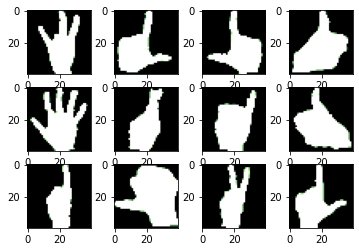

In [107]:
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(dataset[random.randrange(0, len(dataset))][0].permute(1,2,0))

In [108]:
torch.manual_seed(1)
val_size = len(dataset) // 4
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
test_ds = testset
print(len(train_ds), len(val_ds), len(test_ds))

input_size = 3*40*40
output_size = 3

13500 4500 6000


In [109]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [110]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, pin_memory=True)

device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [111]:
class CnnModel1(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(3, 150, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(150, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(60000, 256),
            nn.ReLU(),   
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(32, len(classes)))
        
    def forward(self, xb):
        return self.network(xb)

    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                   
        loss = F.cross_entropy(out, labels)  
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = self.accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [112]:
class CnnModel2(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(3, 150, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(150, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(60000, 64),   
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(32, len(classes)))
        
    def forward(self, xb):
        return self.network(xb)

    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                   
        loss = F.cross_entropy(out, labels)  
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = self.accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [113]:
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

In [114]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [115]:
model1 = to_device(CnnModel1(), device)
model2 = to_device(CnnModel2(), device)

num_epochs = 5
opt_func = torch.optim.Adam

lr = 0.0001

In [101]:
history1 = fit(num_epochs, lr, model1, train_dl, val_dl, opt_func)
history2 = fit(num_epochs, lr, model2, train_dl, val_dl, opt_func)

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.9544, val_loss: 0.0487, val_acc: 0.9922


  0%|          | 0/211 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.1651, val_loss: 0.0102, val_acc: 0.9983


  0%|          | 0/211 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0887, val_loss: 0.0084, val_acc: 0.9976


  0%|          | 0/211 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0692, val_loss: 0.0017, val_acc: 0.9996


  0%|          | 0/211 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0570, val_loss: 0.0035, val_acc: 0.9989


  0%|          | 0/211 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.1060, val_loss: 0.1026, val_acc: 0.9881


  0%|          | 0/211 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.2524, val_loss: 0.0296, val_acc: 0.9954


  0%|          | 0/211 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.1427, val_loss: 0.0115, val_acc: 0.9976


  0%|          | 0/211 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0933, val_loss: 0.0070, val_acc: 0.9991


  0%|          | 0/211 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0779, val_loss: 0.0071, val_acc: 0.9987


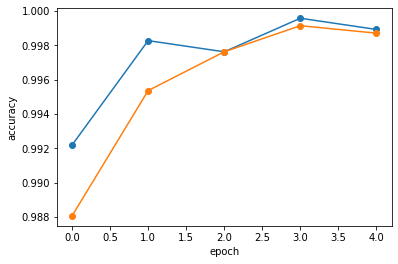

In [102]:
accuracies1 = [x['val_acc'] for x in history1]
accuracies2 = [x['val_acc'] for x in history2]

plt.plot(accuracies1, '-o')
plt.plot(accuracies2, '-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

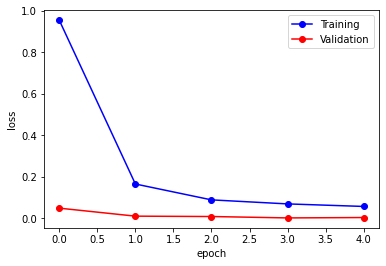

In [103]:
train_losses = [x.get('train_loss') for x in history1]
val_losses = [x['val_loss'] for x in history1]
plt.plot(train_losses, '-bo')
plt.plot(val_losses, '-ro')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.show()

In [104]:
from sklearn.metrics import classification_report

pred = []
Y = []
for i, (x,y) in enumerate(test_loader):
    with torch.no_grad():
        outputs = model1(x)
    pred += [int(op.argmax()) for op in outputs]
    Y += [int(yi) for yi in y]

print(classification_report(Y, pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       300
           1       0.97      1.00      0.99       300
           2       1.00      1.00      1.00       300
           3       0.99      1.00      1.00       300
           4       1.00      1.00      1.00       300
           5       1.00      0.97      0.99       300
           6       1.00      1.00      1.00       300
           7       1.00      1.00      1.00       300
           8       1.00      0.99      1.00       300
           9       1.00      1.00      1.00       300
          10       1.00      0.99      1.00       300
          11       1.00      1.00      1.00       300
          12       1.00      1.00      1.00       300
          13       0.99      1.00      1.00       300
          14       0.99      0.98      0.98       300
          15       1.00      0.99      0.99       300
          16       0.99      1.00      1.00       300
          17       1.00    